# Neuron only analysis


Load in all the required packages

In [1]:
library(igraph)
library(Seurat)
library(dplyr)
library(magrittr)
IRdisplay::display_html("<style> .container { width:95% !important; } </style>")
library("ggplot2")
library("xlsx")
library(tidyr)
library(cowplot)
library(svglite)
library(data.table)
library(scales)
library(RColorBrewer)
library(gplots)

Warning message:
"package 'igraph' was built under R version 4.1.3"

Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Warning message:
"package 'Seurat' was built under R version 4.1.3"
Attaching SeuratObject

Attaching sp

Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:igraph':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'magrittr' was built under R version 4.1.3"


Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'xlsx' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.3"

Attaching package: 'tidyr'


The following object is masked from 'package:magrittr':

    extract


The following object is masked from 'package:igraph':

    crossing


Warning message:
"package 'cowplot' was built under R version 4.1.3"
Warning message:
"package 'svglite' was built under R version 4.1.3"
Warning message:
"package 'data.table' was built under R version 4.1.3"

Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


Warning message:
"package 'scales' was built under R version 4.1.3"
Warning message:
"package 'gplots' was built under R version 4.1.3"

Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess




## Load in the data (stored as .rds files)

In [2]:
#VTA.integrated is the main seurat file that contains all information regarding group identity, cell cluster assignments and more
VTA.integrated<-readRDS(file="./VTA_integrated.rds")

In [3]:
#These .rds files are loading in the group data as separate variables in case we need to refer back to them for cell barcodes specifically belonging to each group
VTA_YFP <- readRDS(file = "./VTA_YFP.rds")
VTA_LH <- readRDS(file = "./VTA_LH.rds")
VTA_PFC <- readRDS(file = "./VTA_PFC.rds")
VTA_NAc <- readRDS(file = "./VTA_NAc.rds")

### Reassigning identities

When we first load in the .rds files, the cell cluster identites are unlabeled, or are denoted by a number instead of a real name (e.g. 0 instead of "Glu1"). This is so that everytime we load in the .rds, we can easily assign any names we want to 

In [4]:
#the table() function allows us to count the nubmer of cells in each Ident (cluster identity)
table(Idents(VTA.integrated))


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
1448  818  817  794  768  726  677  623  466  444  361  336  332  309  246  114 
  16 
  57 

In [5]:
#new.ident will redefine the cluster numbers to the labels below. With CoEx labels.
new.ident <- c("Glu1","CoEx1","Gaba1","DA1","DA2","Gaba2","Glu2","Glu3","Glu4","DA3","Glu5","Glu6","Glu7","CoEx2","CoEx3","Gaba3","Gaba4")
names(x = new.ident) <- levels(x =VTA.integrated)
VTA.integrated<- RenameIdents(object =VTA.integrated, new.ident)

In [6]:
#calling table(Ident()) again will tabulate the number of cells under their new names. The # of cells should be exactly the same as the last time you called table(Ident())
table(Idents(VTA.integrated))


 Glu1 CoEx1 Gaba1   DA1   DA2 Gaba2  Glu2  Glu3  Glu4   DA3  Glu5  Glu6  Glu7 
 1448   818   817   794   768   726   677   623   466   444   361   336   332 
CoEx2 CoEx3 Gaba3 Gaba4 
  309   246   114    57 

This for loop below adds each stim group name to the end of "barcode" for every cell, such that cells belonging to the YFP group will be labeled with "_barcode_VTA_YFP" and so on...Notice how we are now referencing the VTA_YFP variable for the barcodes

In [7]:
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(VTA.integrated@assays$RNA@data[,which(Idents(object=VTA.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
assign(paste(new.ident[i],"_barcode_VTA_YFP",sep=""),intersect(colnames(VTA_YFP@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_VTA_LH",sep=""),intersect(colnames(VTA_LH@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_VTA_NAc",sep=""),intersect(colnames(VTA_NAc@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_VTA_PFC",sep=""),intersect(colnames(VTA_PFC@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
}

In [8]:
barcode_names <- unique(paste(Idents(VTA.integrated),"_barcode",sep=""))

In [9]:
celltype<-vector()
for (i in 1:dim(VTA.integrated@meta.data)[1]){
    celltype[i]<-toString(new.ident[VTA.integrated@meta.data$integrated_snn_res.0.5[i]])
}
VTA.integrated@meta.data$celltype<-celltype

## correlating IEG score with ion channel expression

In [10]:
DefaultAssay(VTA.integrated) <- "RNA"

In [11]:
#Get combined list of ion channels
KCh<-read.csv(file="./Potassium Channels.csv")
KCh<-c(KCh$Symbol)
KCh<-unique(KCh)

NaCh<-read.csv(file="./Sodium Channels.csv")
NaCh<-c(NaCh$Symbol)
NaCh<-unique(NaCh)

CaCh<-read.csv(file="./Calcium Channels.csv")
CaCh<-c(CaCh$Symbol)
CaCh<-unique(CaCh)


All.Ch<-c(KCh, NaCh, CaCh)

#removing TARPs
All.Ch<-All.Ch[! All.Ch %in% c('Cacng2','Cacng3','Cacng4','Cacng5','Cacng7','Cacng8')]

In [12]:
length(All.Ch)

[1] 130

In [13]:
AllIEGs <- read.xlsx("./IEG list.xlsx",sheetIndex=1,header=FALSE)
  
AllIEGlist<-AllIEGs$X1     

In [14]:
#Isloate just DA neurons
DAneurons<-subset(x = VTA.integrated, subset = celltype == "DA1"|celltype == "DA2" |celltype == "DA3")

In [15]:
#Get expression data for IEGs and for all channels
assay.data<-data.frame(GetAssayData(DAneurons, slot='data'))

assay.data.un<-data.frame(lapply(assay.data,expm1))
rownames(assay.data.un)<-rownames(assay.data)
assay.data<-assay.data.un

assay.data.AllCh <- assay.data[rownames(assay.data) %in% All.Ch,]
assay.data.IEG <- assay.data[rownames(assay.data) %in% AllIEGlist,]

In [16]:
#Find genes expressed in >25% of cells in at least one DA cluster
dot.data<-DotPlot(VTA.integrated, feature=unique(All.Ch))$data
dot.data.pct<-dcast(dot.data, features.plot~id, value.var='pct.exp')

Ch.25<-dot.data.pct[(dot.data.pct$DA1>=25|dot.data.pct$DA2>=25|dot.data.pct$DA3>=25),]
rownames(Ch.25)<-Ch.25$features.plot
Ch.25.genes<-row.names(Ch.25)



Warning message in dcast(dot.data, features.plot ~ id, value.var = "pct.exp"):
"The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(dot.data). In the next version, this warning will become an error."


In [17]:
# narrowing assay data to Ch.25.genes

assay.data.AllCh<-assay.data.AllCh[rownames(assay.data.AllCh) %in% Ch.25.genes,]

In [18]:
# Get combined IEG score
IEGscore<-as.data.frame(colSums(assay.data.IEG))
colnames(IEGscore)<-'IEGscore'

# Transpose rows and columns of channel data
ChannelData <- data.frame(t(assay.data.AllCh))
colnames(ChannelData) <- rownames(assay.data.AllCh)

#combine IEGscore and channel data
IEGandChannel<-cbind(IEGscore, ChannelData)

### first make heatmap of ion channel genes without IEG score

In [19]:
#run correlation
ChannelData.cor<-cor(ChannelData)

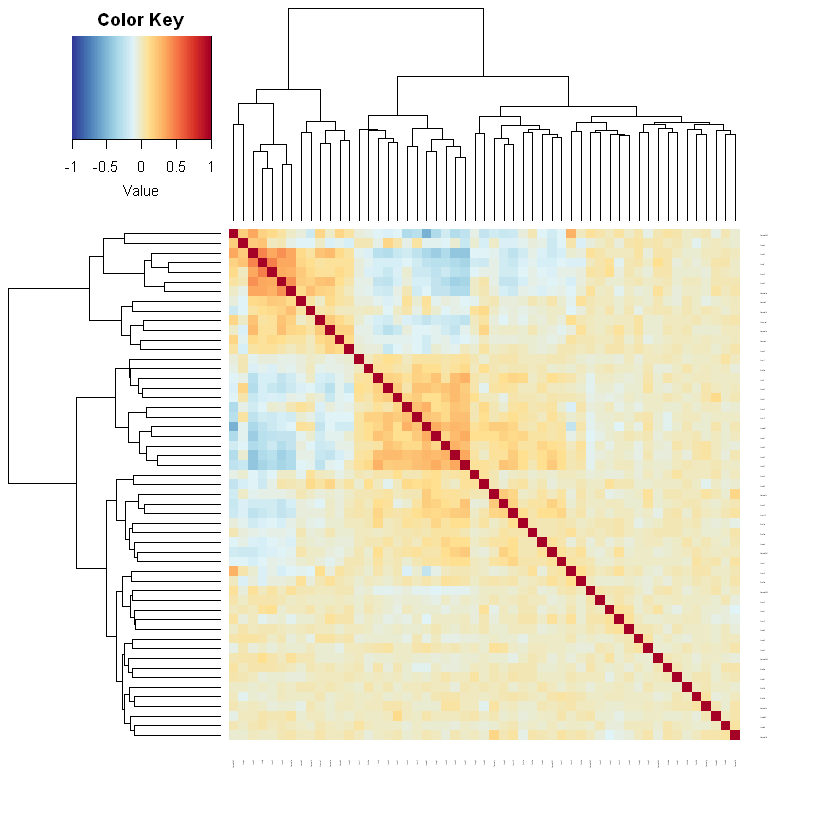

In [20]:
mybreaks<-c(seq(0,1, length.out=101))
palette <- colorRampPalette(rev(brewer.pal(10, "RdYlBu")))(100)

heatmap.2(x=ChannelData.cor, symm=TRUE, col=palette, key=TRUE, trace='none', revC=TRUE, density.info='none' ,cexRow=0.1, cexCol=0.1

       )
#png(file="./heatmapall.png")
#heatmap.2(x=ChannelData.cor, symm=TRUE, col=palette, key=TRUE, trace='none', revC=TRUE, density.info='none',cexRow=0.1, cexCol=0.1 ) #
#dev.off()

### now make heatmap of select genes with IEG score

In [21]:
genes<-c('IEGscore','Kcnd3','Kcnj6','Kcns3','Kcnn3','Cacna1a', 'Kcnc2','Kcnt2','Kcnab1','Kcnip1','Kcnh5','Kcnd2','Kcnh7')

In [22]:
IEGandChannel<-IEGandChannel[,colnames(IEGandChannel) %in% genes]

In [23]:
#run correlation
IEGandChannel.cor<-cor(IEGandChannel)

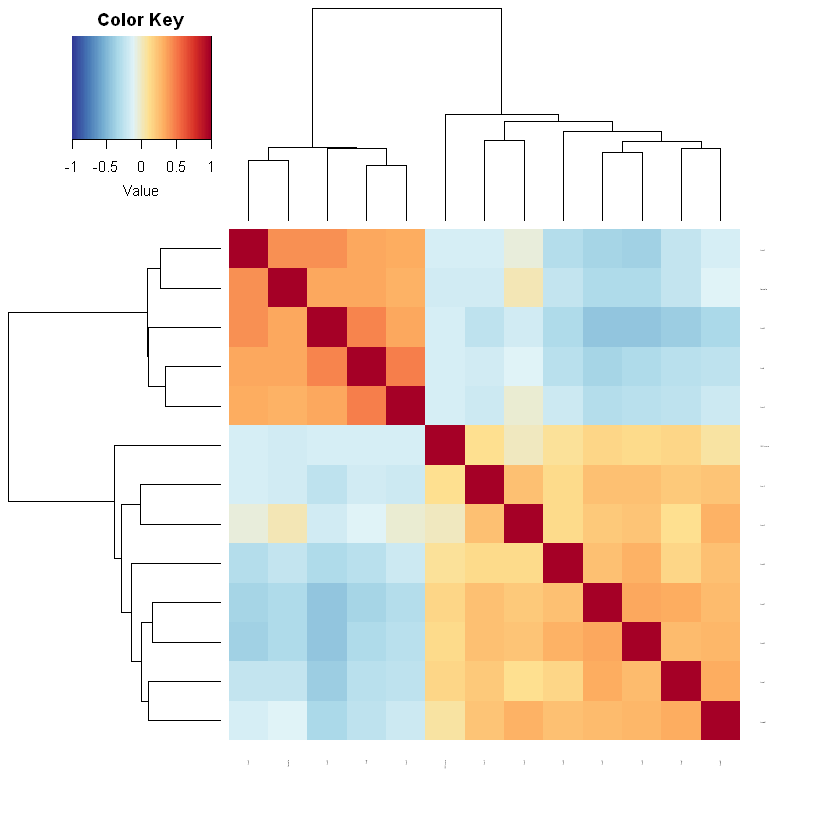

In [24]:
mybreaks<-c(seq(0,1, length.out=101))
palette <- colorRampPalette(rev(brewer.pal(10, "RdYlBu")))(100)

heatmap.2(x=IEGandChannel.cor, symm=TRUE, col=palette, key=TRUE, trace='none', revC=TRUE, density.info='none' ,cexRow=0.1, cexCol=0.1

       )
#pdf(file="./heatmapforfaseb.pdf")
#heatmap.2(x=IEGandChannel.cor, symm=TRUE, col=palette, key=TRUE, trace='none', revC=TRUE, density.info='none',cexRow=0.2, cexCol=0.2 ) #
#dev.off()

### split by stim

In [25]:
genes<-c('IEGscore','Kcnd3','Kcnj6','Kcns3','Kcnn3','Cacna1a', 'Kcnc2','Kcnt2','Kcnab1','Kcnip1','Kcnh5','Kcnd2','Kcnh7')

In [26]:
#Get expression data for selected channels and all IEGs
#list 'genes' defined above

assay.data<-data.frame(GetAssayData(DAneurons, slot='data'))

assay.data.un<-data.frame(lapply(assay.data,expm1))
rownames(assay.data.un)<-rownames(assay.data)
assay.data<-assay.data.un

assay.data.AllCh <- assay.data[rownames(assay.data) %in% genes,]
assay.data.IEG <- assay.data[rownames(assay.data) %in% AllIEGlist,]

In [27]:
# Get combined IEG score
IEGscore<-as.data.frame(colSums(assay.data.IEG))
colnames(IEGscore)<-'IEGscore'

# Transpose rows and columns of channel data
ChannelData <- data.frame(t(assay.data.AllCh))
colnames(ChannelData) <- rownames(assay.data.AllCh)

#combine IEGscore and channel data, rename IEGandCorgenes
IEGandCorgenes<-cbind(IEGscore, ChannelData)

In [28]:
#Split by stim
IEGandCorgenes.YFP<-IEGandCorgenes[grep('YFP', rownames(IEGandCorgenes)), ]
IEGandCorgenes.PFC<-IEGandCorgenes[grep('PFC', rownames(IEGandCorgenes)), ]
IEGandCorgenes.NAc<-IEGandCorgenes[grep('NAc', rownames(IEGandCorgenes)), ]
IEGandCorgenes.LH<-IEGandCorgenes[grep('LH', rownames(IEGandCorgenes)), ]

In [29]:
#run correlations
IEGandCorgenes.YFP.cor<-cor(IEGandCorgenes.YFP)
IEGandCorgenes.PFC.cor<-cor(IEGandCorgenes.PFC)
IEGandCorgenes.NAc.cor<-cor(IEGandCorgenes.NAc)
IEGandCorgenes.LH.cor<-cor(IEGandCorgenes.LH)

In [30]:
#combine correlated values for all groups
IEGcorvalues.YFP<-as.data.frame(IEGandCorgenes.YFP.cor)
IEGcorvalues.PFC<-as.data.frame(IEGandCorgenes.PFC.cor)
IEGcorvalues.NAc<-as.data.frame(IEGandCorgenes.NAc.cor)
IEGcorvalues.LH<-as.data.frame(IEGandCorgenes.LH.cor)

IEGscoreonly.YFP<-data.frame(IEGcorvalues.YFP$IEGscore)
IEGscoreonly.PFC<-data.frame(IEGcorvalues.PFC$IEGscore)
IEGscoreonly.NAc<-data.frame(IEGcorvalues.NAc$IEGscore)
IEGscoreonly.LH<-data.frame(IEGcorvalues.LH$IEGscore)

rownames(IEGscoreonly.YFP)<-rownames(IEGcorvalues.YFP)
rownames(IEGscoreonly.PFC)<-rownames(IEGcorvalues.PFC)
rownames(IEGscoreonly.NAc)<-rownames(IEGcorvalues.NAc)
rownames(IEGscoreonly.LH)<-rownames(IEGcorvalues.LH)

IEGscoreonly.YFP$id <- rownames(IEGscoreonly.YFP)
IEGscoreonly.PFC$id <- rownames(IEGscoreonly.PFC)
IEGscoreonly.NAc$id <- rownames(IEGscoreonly.NAc)
IEGscoreonly.LH$id <- rownames(IEGscoreonly.LH)

#sort alphabetically first
IEGscoresort.YFP<- IEGscoreonly.YFP[order(IEGscoreonly.YFP$id),]
IEGscoresort.PFC<- IEGscoreonly.PFC[order(IEGscoreonly.PFC$id),]
IEGscoresort.NAc<- IEGscoreonly.NAc[order(IEGscoreonly.NAc$id),]
IEGscoresort.LH<- IEGscoreonly.LH[order(IEGscoreonly.LH$id),]

#combine
IEGscore.comb<-cbind(IEGscoresort.YFP[,1], IEGscoresort.PFC[,1], IEGscoresort.NAc[,1],IEGscoresort.LH[,1:2])
colnames(IEGscore.comb)<-c('YFP','PFC','NAc','LH','id')

#sort by YFP cor score
IEGscore.comb<-IEGscore.comb[order(IEGscore.comb$YFP, decreasing=TRUE),]

IEGscore.comb<-na.omit(IEGscore.comb)
IEGscore.comb<-IEGscore.comb[-grep('IEG', rownames(IEGscore.comb)), ]

In [31]:
IEGscore.comb$id <- factor(IEGscore.comb$id, levels=c(rownames(IEGscore.comb)))
IEGscore.comb.melt <- melt(IEGscore.comb)
IEGscore.comb.melt$variable <- factor(IEGscore.comb.melt$variable, levels=c('YFP','PFC','NAc','LH'))


Warning message in melt(IEGscore.comb):
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(IEGscore.comb). In the next version, this warning will become an error."
Using id as id variables



Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."
Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


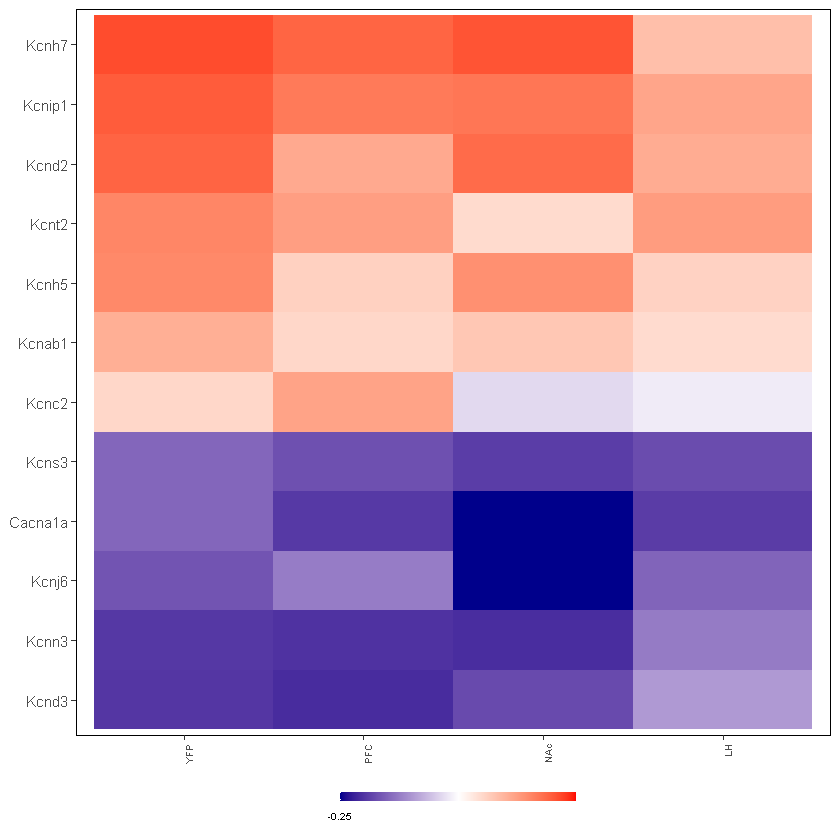

In [32]:
#Make heatplot
low <- -0.25
high <- 0.25

#fordiffgenes
ggplot(IEGscore.comb.melt, aes(x=variable, y=id, fill=value)) +

theme_classic()+
theme(axis.text.x=element_text( size=6, angle=90, hjust=1),
            plot.title = element_text(size=6),
            panel.background = element_rect(colour = "black", size=.25, fill=NA),
            axis.line.y = element_blank(),
            axis.line.x=element_blank(),
            axis.title.y = element_blank(),
            axis.ticks.x = element_line(size=0.25),
            axis.title.x = element_blank(),
            legend.key.height= unit(0.2, 'cm'), 
            legend.key.width = unit(1.0, 'cm'),
            legend.position = "bottom",
            legend.text = element_text(size=6),
            legend.title = element_blank())+
             scale_y_discrete(limits=rev)+
    geom_tile() +
    scale_fill_gradient2(limits=c(low, high), breaks=seq(low,high,by=5),low = "darkblue",mid="white",midpoint=0,high = "red",oob=squish)
#ggsave('./Corgenes heatplot.pdf',width=5, height=10)

### plotting across other cell types

In [33]:
#Split by celltype
DAneurons<-subset(x = VTA.integrated, subset = celltype == "DA1"|celltype == "DA2" |celltype == "DA3")
GABAneurons<-subset(x= VTA.integrated, subset = celltype == 'Gaba1'| celltype == 'Gaba2' | celltype == 'Gaba3' | celltype == 'Gaba4')
Gluneurons<-subset(x= VTA.integrated, subset = celltype == 'Glu1'| celltype == 'Glu2' | celltype == 'Glu3' | celltype == 'Glu4'| celltype == 'Glu5' | celltype == 'Glu6' | celltype == 'Glu7')
CoExneurons<-subset(x = VTA.integrated, subset = celltype == "CoEx1"|celltype == "CoEx2" |celltype == "CoEx3")

In [34]:
#Get expression data for IEGs and for select genes
assay.data.DA<-data.frame(GetAssayData(DAneurons, slot='data'))
assay.data.GABA<-data.frame(GetAssayData(GABAneurons, slot='data'))
assay.data.Glu<-data.frame(GetAssayData(Gluneurons, slot='data'))
assay.data.CoEx<-data.frame(GetAssayData(CoExneurons, slot='data'))


assay.data.un.DA<-data.frame(lapply(assay.data.DA,expm1))
rownames(assay.data.un.DA)<-rownames(assay.data.DA)
assay.data.DA<-assay.data.un.DA

assay.data.un.GABA<-data.frame(lapply(assay.data.GABA,expm1))
rownames(assay.data.un.GABA)<-rownames(assay.data.GABA)
assay.data.GABA<-assay.data.un.GABA

assay.data.un.Glu<-data.frame(lapply(assay.data.Glu,expm1))
rownames(assay.data.un.Glu)<-rownames(assay.data.Glu)
assay.data.Glu<-assay.data.un.Glu

assay.data.un.CoEx<-data.frame(lapply(assay.data.CoEx,expm1))
rownames(assay.data.un.CoEx)<-rownames(assay.data.CoEx)
assay.data.CoEx<-assay.data.un.CoEx


#Using to plot genes defined above

assay.data.corgenes.DA <- assay.data.DA[rownames(assay.data.DA) %in% genes,]
assay.data.IEG.DA <- assay.data.DA[rownames(assay.data.DA) %in% AllIEGlist,]

assay.data.corgenes.GABA <- assay.data.GABA[rownames(assay.data.GABA) %in% genes,]
assay.data.IEG.GABA <- assay.data.GABA[rownames(assay.data.GABA) %in% AllIEGlist,]

assay.data.corgenes.Glu <- assay.data.Glu[rownames(assay.data.Glu) %in% genes,]
assay.data.IEG.Glu <- assay.data.Glu[rownames(assay.data.Glu) %in% AllIEGlist,]

assay.data.corgenes.CoEx <- assay.data.CoEx[rownames(assay.data.CoEx) %in% genes,]
assay.data.IEG.CoEx <- assay.data.CoEx[rownames(assay.data.CoEx) %in% AllIEGlist,]

In [35]:
# Transpose rows and columns of channel data
CorGenesData.DA <- data.frame(t(assay.data.corgenes.DA))
colnames(CorGenesData.DA) <- rownames(assay.data.corgenes.DA)

CorGenesData.GABA <- data.frame(t(assay.data.corgenes.GABA))
colnames(CorGenesData.GABA) <- rownames(assay.data.corgenes.GABA)

CorGenesData.Glu <- data.frame(t(assay.data.corgenes.Glu))
colnames(CorGenesData.Glu) <- rownames(assay.data.corgenes.Glu)

CorGenesData.CoEx <- data.frame(t(assay.data.corgenes.CoEx))
colnames(CorGenesData.CoEx) <- rownames(assay.data.corgenes.CoEx)

In [36]:
# Get combined IEG score
IEGscore.DA<-as.data.frame(colSums(assay.data.IEG.DA))
colnames(IEGscore.DA)<-'IEGscore'

IEGscore.GABA<-as.data.frame(colSums(assay.data.IEG.GABA))
colnames(IEGscore.GABA)<-'IEGscore'

IEGscore.Glu<-as.data.frame(colSums(assay.data.IEG.Glu))
colnames(IEGscore.Glu)<-'IEGscore'

IEGscore.CoEx<-as.data.frame(colSums(assay.data.IEG.CoEx))
colnames(IEGscore.CoEx)<-'IEGscore'

In [37]:
#combine IEGscore and channel data
IEGandCorgenes.DA<-cbind(IEGscore.DA, CorGenesData.DA)
IEGandCorgenes.GABA<-cbind(IEGscore.GABA, CorGenesData.GABA)
IEGandCorgenes.Glu<-cbind(IEGscore.Glu, CorGenesData.Glu)
IEGandCorgenes.CoEx<-cbind(IEGscore.CoEx, CorGenesData.CoEx)

In [38]:
#run correlation
IEGandCorgenes.DA.cor<-cor(IEGandCorgenes.DA)
IEGandCorgenes.GABA.cor<-cor(IEGandCorgenes.GABA)
IEGandCorgenes.Glu.cor<-cor(IEGandCorgenes.Glu)
IEGandCorgenes.CoEx.cor<-cor(IEGandCorgenes.CoEx)

In [39]:
#combine correlated values for all groups
IEGcorvalues.DA<-as.data.frame(IEGandCorgenes.DA.cor)
IEGcorvalues.GABA<-as.data.frame(IEGandCorgenes.GABA.cor)
IEGcorvalues.Glu<-as.data.frame(IEGandCorgenes.Glu.cor)
IEGcorvalues.CoEx<-as.data.frame(IEGandCorgenes.CoEx.cor)

IEGscoreonly.DA<-data.frame(IEGcorvalues.DA$IEGscore)
IEGscoreonly.GABA<-data.frame(IEGcorvalues.GABA$IEGscore)
IEGscoreonly.Glu<-data.frame(IEGcorvalues.Glu$IEGscore)
IEGscoreonly.CoEx<-data.frame(IEGcorvalues.CoEx$IEGscore)

rownames(IEGscoreonly.DA)<-rownames(IEGcorvalues.DA)
rownames(IEGscoreonly.GABA)<-rownames(IEGcorvalues.GABA)
rownames(IEGscoreonly.Glu)<-rownames(IEGcorvalues.Glu)
rownames(IEGscoreonly.CoEx)<-rownames(IEGcorvalues.CoEx)

IEGscoreonly.DA$id <- rownames(IEGscoreonly.DA)
IEGscoreonly.GABA$id <- rownames(IEGscoreonly.GABA)
IEGscoreonly.Glu$id <- rownames(IEGscoreonly.Glu)
IEGscoreonly.CoEx$id <- rownames(IEGscoreonly.CoEx)

#sort alphabetically first
IEGscoresort.DA<- IEGscoreonly.DA[order(IEGscoreonly.DA$id),]
IEGscoresort.GABA<- IEGscoreonly.GABA[order(IEGscoreonly.GABA$id),]
IEGscoresort.Glu<- IEGscoreonly.Glu[order(IEGscoreonly.Glu$id),]
IEGscoresort.CoEx<- IEGscoreonly.CoEx[order(IEGscoreonly.CoEx$id),]

#combine
IEGscore.comb<-cbind(IEGscoresort.DA[,1], IEGscoresort.GABA[,1], IEGscoresort.Glu[,1],IEGscoresort.CoEx[,1:2])
colnames(IEGscore.comb)<-c('DA','GABA','Glu','CoEx','id')

#sort by DA cor score
IEGscore.comb<-IEGscore.comb[order(IEGscore.comb$DA, decreasing=TRUE),]

IEGscore.comb<-na.omit(IEGscore.comb)
IEGscore.comb<-IEGscore.comb[-grep('IEG', rownames(IEGscore.comb)), ]

In [40]:
IEGscore.comb$id <- factor(IEGscore.comb$id, levels=c(rownames(IEGscore.comb)))
IEGscore.comb.melt <- melt(IEGscore.comb)
IEGscore.comb.melt$variable <- factor(IEGscore.comb.melt$variable, levels=c('DA','GABA','Glu','CoEx'))

Warning message in melt(IEGscore.comb):
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(IEGscore.comb). In the next version, this warning will become an error."
Using id as id variables



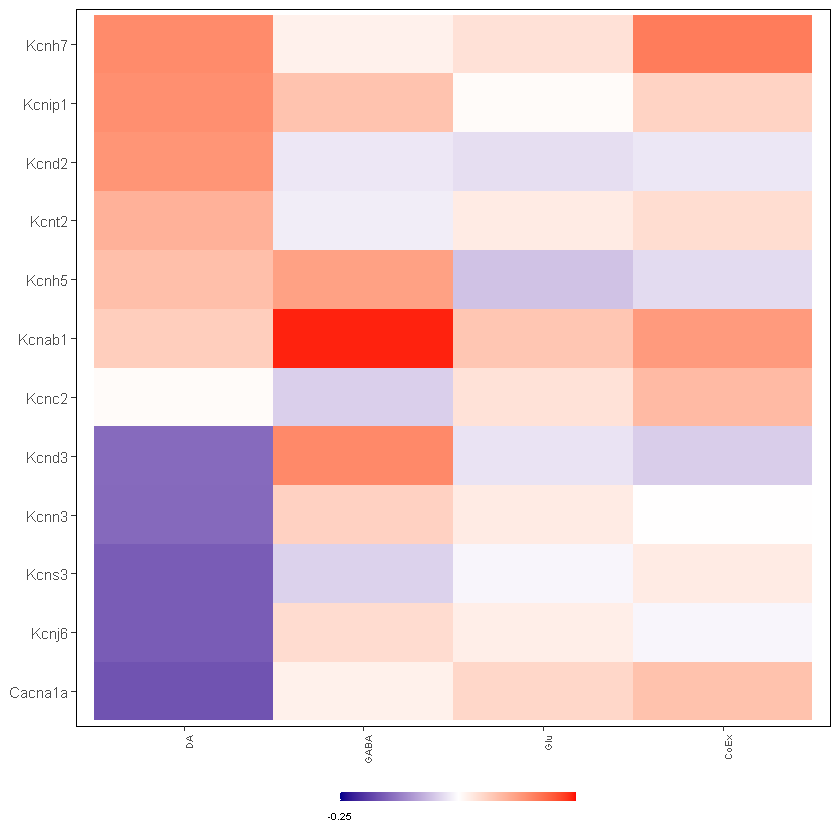

In [41]:
#Make heatplot
low <- -0.25
high <- 0.25

#fordiffgenes
ggplot(IEGscore.comb.melt, aes(x=variable, y=id, fill=value)) +

theme_classic()+
theme(axis.text.x=element_text( size=6, angle=90, hjust=1),
            plot.title = element_text(size=6),
            panel.background = element_rect(colour = "black", size=.25, fill=NA),
            axis.line.y = element_blank(),
            axis.line.x=element_blank(),
            axis.title.y = element_blank(),
            axis.ticks.x = element_line(size=0.25),
            axis.title.x = element_blank(),
            legend.key.height= unit(0.2, 'cm'), 
            legend.key.width = unit(1.0, 'cm'),
            legend.position = "bottom",
            legend.text = element_text(size=6),
            legend.title = element_blank())+
             scale_y_discrete(limits=rev)+
    geom_tile() +
    scale_fill_gradient2(limits=c(low, high), breaks=seq(low,high,by=5),low = "darkblue",mid="white",midpoint=0,high = "red",oob=squish)
#ggsave('./Corgenes heatplot other celltypes.pdf',width=5, height=10)

# disc plot

In [42]:
DefaultAssay(VTA.integrated) <- "RNA"

In [43]:
levels(VTA.integrated) <- ((c("DA1","DA2","DA3","Gaba1","Gaba2","Gaba3","Gaba4","Glu1","Glu2","Glu3","Glu4","Glu5","Glu6","Glu7","CoEx1","CoEx2","CoEx3")))

In [44]:
gene_list<-c('Kcnd3','Kcnn3','Kcnj6','Cacna1a','Kcns3','Kcnc2','Kcnab1','Kcnh5','Kcnt2','Kcnd2','Kcnip1','Kcnh7')

Warning message:
"Scaling data with a low number of groups may produce misleading results"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


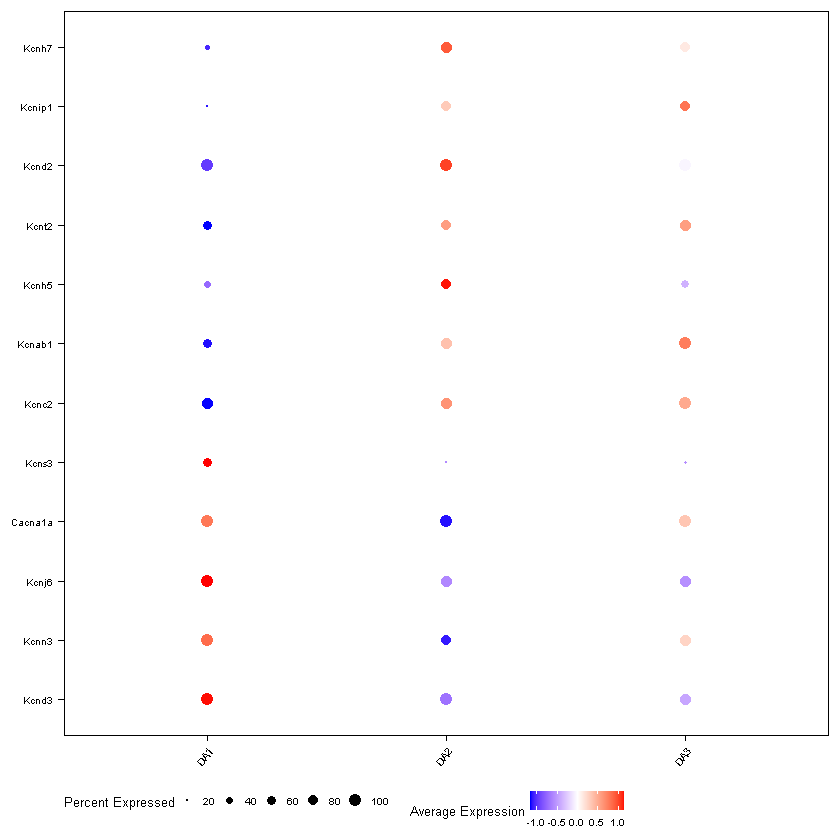

In [45]:
#three color
DotPlot(VTA.integrated, feature=gene_list, scale=TRUE, id=c('DA1','DA2','DA3'))  + 
scale_colour_gradient2(low = "blue", mid = "white", high = "red") +
theme(axis.title=element_blank(),
          axis.text.y=element_text(size=6,colour = "black"),
          axis.text.x=element_text(size=6,angle = 50, hjust =1,colour = "black"),
          axis.line = element_blank(),
          axis.ticks = element_line(size=0.25),
          legend.key.size = unit(0.4, "cm"),
          panel.background = element_rect(colour = "black", size=.25, fill=NA),
          legend.title = element_text(size=8),
          legend.text = element_text(size=6),
          legend.position='bottom') +
scale_size_continuous(range = c(0,3)) +
coord_flip()
